In [1]:
%cd ../
%config InlineBackend.figure_format='retina'

import altair as alt
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from scipy.stats.stats import zscore
from src.canonical_analysis.subspace_comm import CCARepeatedStim
from src.gabor_analysis.gabor_fit import GaborFit
from src.power_law.subtract_spont import SubtractSpontAnalyzer
from src.spikeloader import SpikeLoader

alt.data_transformers.disable_max_rows()
sns.set()

/groups/stringer/home/josephs2/janelia2020


In [2]:
path_loader = "data/superstim_TX57.hdf5"
path_gabor = "data/superstim_TX57.hdf5"

In [3]:
# Parameters
path_npz = (
    "/groups/pachitariu/pachitariulab/datasets/v1RF/text32_500_TX57_2020_08_18.npz"
)
path_hdf5 = "/groups/stringer/home/josephs2/data/text32_500_TX57_2020_08_18.hdf5"
path_img = "/groups/pachitariu/pachitariulab/data/STIM/text32_500.mat"
path_loader = "/groups/stringer/home/josephs2/data/text32_500_TX57_2020_08_18.hdf5"
path_rf = "/groups/stringer/home/josephs2/data/text32_500_TX57_2020_08_18.hdf5"
path_gabor = "/groups/stringer/home/josephs2/data/text32_500_TX57_2020_08_18.hdf5"


In [4]:
loader = SpikeLoader.from_hdf5(path_loader)
gabor = GaborFit.from_hdf5(path_gabor)

idx_spont = loader.idx_spont
spks = zscore(loader.spks, axis=0)
spks_nospont = SubtractSpontAnalyzer(128).fit(spks, loader.idx_spont).transform(spks)

dict_keys(['cls', 'path', 'load_prev_run', 'kwargs'])
<class 'src.spikeloader.SpikeLoader'>
/groups/stringer/home/josephs2/data/text32_500_TX57_2020_08_18.hdf5
True
{}
dict_keys(['cls', 'path', 'load_prev_run', 'kwargs'])
<class 'src.gabor_analysis.gabor_fit.GaborFit'>
/groups/stringer/home/josephs2/data/text32_500_TX57_2020_08_18.hdf5
True
{}


/groups/stringer/home/josephs2/anaconda3-2020/lib/python3.8/site-packages/jax/lib/xla_bridge.py:130: UserWarning: No GPU/TPU found, falling back to CPU.
  warnings.warn('No GPU/TPU found, falling back to CPU.')


idx_spont [    0     1     3 ... 26746 26748 26750]


# Canonical Correlation Analysis - Stimuli

We use CCA to capture the largest modes of the spiking data that are common to both neuron groups.

Let $X$ and $Y$ be $(n \times p_i)$ matrices where $n$ is the number of stimuli and $p_i$ is the number of neurons in each group. Random group assignment is based on a checkerboard pattern to avoid signal contamination between adjacent neurons.

Neuron assignment to each group never changes in the following analysis.

128 PCs of spontaneous activity (brain activity when no stimuli are shown) are subtracted from the main dataset.

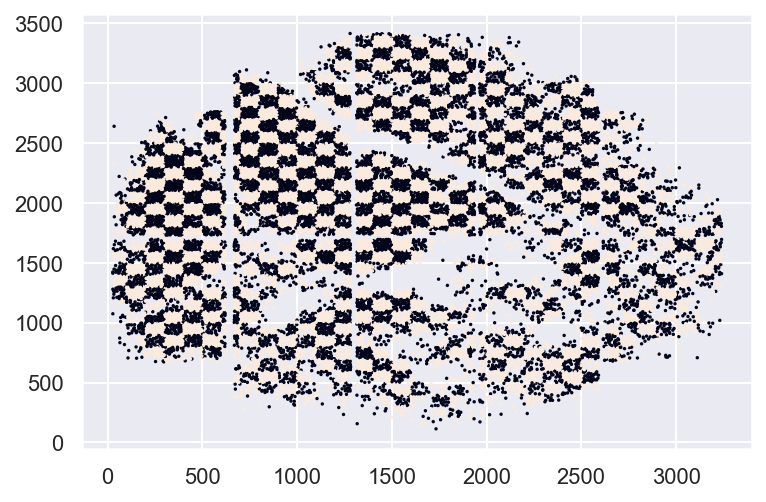

In [5]:
def prepare_df(df_all: pd.DataFrame):
    df_all = df_all.copy()
    df_all["region"] = "brain"

    def checkerboard(item: pd.Series):
        if ((item.x // 100) + (item.y // 100)) % 2 == 0:
            return 0
        else:
            return 1

    df_all["group"] = df_all.apply(checkerboard, axis=1).astype("category")
    return df_all


regions = {"brain": (dict(group=0), dict(group=1))}

cr = CCARepeatedStim(loader, gabor, prepare_df=prepare_df, regions=regions)
plt.scatter(cr.df.x, cr.df.y, c=cr.df.group, s=0.5)

### Training

The training data are used to generate the canonical vectors and testing data are used to calculate the canonical coefficients.

Here, we use spikes from non-repeated stimuli as the training data. 

In [6]:
ns_train = [20000]
rep, no_rep = loader.get_idx_rep(return_onetimers=True)
with cr.set_spks_source(spks_nospont[loader.istim.index, :]):
    df_un = cr.calc_cr(ns_train, idx_train=no_rep)

### Testing

We investigate how the canonical coefficients vary when we compare the neural activity from group 1 and group 2 neurons from
1. same time points
2. same stimuli but different time points
3. different stimuli and different time points
4. same time points from the training set
5. spontaneous time points.

Note that we are comparing the projection of the canonical vectors from two different neuron groups.
The legend means [stim used for projection from group1]_[stim used for projection from group2].

The left graph shows the canonical coefficients (correlation) whereas the right graph shows the cross-covariance (unnormalized correlation).

In [7]:
n_rep = loader.get_idx_rep().shape[0]
rand = np.random.default_rng(42)

with cr.set_spks_source(spks_nospont):
    innerprod_between_tests = [
        cr.calc_innerprod_test(
            df_un,
            idxs_test={
                "rep1": cr.loader.get_idx_rep(stim_idx=False)[:, 0],
                "rep2": cr.loader.get_idx_rep(stim_idx=False)[:, 1],
                "rand_training": rand.choice(np.arange(len(cr.S)), size=n_rep, replace=False),
                "spont": cr.loader.idx_spont[:n_rep],
            },
            pairs=[
                ("rep1", "rep1"),
                ("rep1", "rep2"),
                ("rand_training", "rand_training"),
                ("rep1", "rand_training"),
                ("spont", "spont"),
            ],
            normalize=boo,
        )
        for boo in [True, False]
    ]

In [8]:
def gen_chart(data: pd.DataFrame) -> alt.Chart:
    y = "cov" if "cov" in data.columns else "corr"
    selection = alt.selection_multi(fields=["match"], bind="legend")
    base = alt.Chart(data).encode(x="dimension", y=y, color="match",)

    return (
        base.mark_line()
        .encode(
            size=alt.condition(~selection, alt.value(1), alt.value(2)),
            opacity=alt.condition(~selection, alt.value(0.4), alt.value(1)),
            row="n:N",
        )
        .properties(width=200, height=250)
        .add_selection(selection)
    )


gen_chart(innerprod_between_tests[0]) | gen_chart(innerprod_between_tests[1])

alt.HConcatChart(...)

### Results

- The correlation between the same stimuli but different time points is less than half that of the same time points.
- Despite subtracting out spontaneous PCs, we still observe high correlation between spontaneous stimuli. However, near zero cross-covariance suggests that most of the variability in the spontaneous subspace has been removed.

As controls:
    - Highest correlations are observed when we compare training data from the same time points.
    - Noise is observed when we attempt to compare unrelated stimuli.

In [9]:

# sns.FacetGrid(
#     data=df_transformed[df_transformed["stim"].isin(rand.integers(low=0, high=n_rep, size=15))],
#     col="stim",
#     col_wrap=5,
# ).map(
#     sns.regplot, "rep1", "rep2", scatter_kws={"s": 1, "alpha": 0.5},
# )
# sns.regplot(
#     "rep1",
#     "rep2",
#     data=df_transformed[df_transformed.stim == 0],
#     ax=ax,
#     scatter_kws={"s": 1, "alpha": 0.5},
# )
# ax.set_aspect("equal")